Env of this notebook is conda env myenv/

In [1]:
!pip uninstall transformers -y
!pip install git+https://github.com/huggingface/transformers@cae78c46d

Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
  Cloning https://github.com/huggingface/transformers (to revision cae78c46d) to /tmp/pip-req-build-t1uoway7
  Running command git clone --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-t1uoway7
  Running command git checkout -q cae78c46d
  Resolved https://github.com/huggingface/transformers to commit cae78c46d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Created wheel for transformers: filename=transformers-4.28.0.dev0-py3-none-any.whl size=6827702 sha256=515eeae8f6282af9209358560ba14b761cb909b7ab78e8e4e2b91d0517736ce5
  Stored in director

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time

In [2]:
# # set env variables, NOTE: this cell must be run first
os.environ['TRANSFORMERS_OFFLINE']="1"

os.environ['TRANSFORMERS_CACHE'] = '/scratch/shareddata/dldata/huggingface-hub-cache/hub'

In [3]:
import torch
# from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer,AutoModelForSeq2SeqLMWithValueHead
from transformers import AutoTokenizer, AutoModelForCausalLM
# ,BitsAndBytesConfig,AutoModelForSeq2SeqLM
# from peft import AutoPeftModelForCausalLM
# from peft import PeftModel, PeftConfig, LoraConfig, TaskType



## Load the model 

In [4]:
model_name = "meta-llama/Llama-2-13b-hf"
# model_name = "gpt2"

**Original Lora paper:** https://arxiv.org/pdf/2106.09685.pdf

In [5]:

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"
)

Loading checkpoint shards: 100%|████████████████████████████████| 3/3 [03:56<00:00, 78.91s/it]


In [13]:
device = model.device
device

device(type='cuda', index=0)

In [6]:

## Print out the layers, data types, and devices

for name, module in model.named_modules():
    for param_name, param in module.named_parameters(recurse=False):
        print(f"Layer: {name}, Parameter: {param_name}, Type: {param.dtype}, Device: {param.device}")

Layer: model.embed_tokens, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.self_attn.q_proj, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.self_attn.k_proj, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.self_attn.v_proj, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.self_attn.o_proj, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.mlp.gate_proj, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.mlp.up_proj, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.mlp.down_proj, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.input_layernorm, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.0.post_attention_layernorm, Parameter: weight, Type: torch.float32, Device: cuda:0
Layer: model.layers.1.self_attn.q_proj, Parameter: weight, Type: to

In [18]:

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

prompt = "How many stars in the space?"

model_inputs = tokenizer([prompt], return_tensors="pt").to(device) 
input_length = model_inputs.input_ids.shape[1]

generated_ids = model.generate(**model_inputs, max_new_tokens=20)
print(tokenizer.batch_decode(generated_ids[:, input_length:], skip_special_tokens=True)[0])


How many stars in the space? This is a very interesting question.
There are about 


## batch inference

In [19]:
prompts = ['How do you like my new hair cut?',
           'Do you like Taylor Swift?'
          ]

In [20]:

inputs = tokenizer(prompts, padding=True,
                   truncation=True,
                   max_length=30, 
                   return_tensors="pt"
                  ).to(device)

# Generate outputs
generation_kwargs = {"max_length": 40, 
                     "top_k": 0.0, 
                     "top_p": 1.0, 
                     "do_sample": True, 
                     "pad_token_id": tokenizer.eos_token_id
                    }

outputs = model.generate(**inputs, **generation_kwargs)
    
# Decode the outputs
responds = tokenizer.batch_decode(outputs, skip_special_tokens=True)


responds

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


['How do you like my new hair cut?\nI have had the same hair cut for a long time. I don’t like going to the hair salon. I have been cutting my',
 'Do you like Taylor Swift? the pop star from United States. We have added the Taylor Swift’s net worth, biography, age, height, weight, etc what you']

## Get rewards

In [15]:
# Use a bert model as the reward function
from transformers import pipeline

classifier = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

In [16]:
results = classifier(responds)
results

[{'label': 'POS', 'score': 0.9766294360160828},
 {'label': 'POS', 'score': 0.9696700572967529}]

In [17]:
rewards = []
for result in results:
    if result['label']=='POS':
        reward = result['score']
    else: reward = -result['score']
    rewards.append(reward)

rewards

[0.9766294360160828, 0.9696700572967529]

## Prepare training tensors: inputs, outputs and rewards 

In [18]:
input_tensors = tokenizer(prompts, padding=True, truncation=True,\
                   max_length=30, return_tensors="pt")['input_ids'].to(device)
input_tensors = []
for prompt in prompts:
    input_ = tokenizer(prompt, padding=True, truncation=True,\
                   max_length=30, return_tensors="pt")['input_ids']
    input_tensors.append(input_.squeeze().to(device))

In [19]:
input_tensors 

[tensor([    1,  1128,   437,   366,   763,   590,   716, 11315,  5700, 29973],
        device='cuda:0'),
 tensor([    1,  1938,   366,   763, 12537, 14156, 29973], device='cuda:0')]

In [20]:
response_tensors = []
for input_tensor in input_tensors:
    response = ppo_trainer.generate(input_tensor, **generation_kwargs)
    response_tensors.append(response.squeeze().to(device))
response_tensors

[tensor([    1,  1128,   437,   366,   763,   590,   716, 11315,  5700, 29973,
            13, 29902,   505,  1063,  7291,  1048,  2805,   263,   447,  2076,
           329,   363,   263,  7303,   310, 11405, 29889,   306,   505,  1063,
          2675,   304,   278,  1021,   447,   765, 29891,  1761,   363,   263],
        device='cuda:0'),
 tensor([    1,  1938,   366,   763, 12537, 14156, 29973,  1938,   366,   763,
           902,  2924,   310,  4696, 29973,    13, 29902,   763, 12537, 14156,
         29892,   541,   306,  1348,   306,   763,   902,   901,   363,  1058,
          1183,   338,  1135,   363,   902,  4696, 29889,    13, 29902,   763],
        device='cuda:0')]

In [21]:
reward_tensors = []
for reward in rewards:
    reward_tensors.append(torch.tensor(reward).to(device)) 
reward_tensors

[tensor(0.9766, device='cuda:0'), tensor(0.9697, device='cuda:0')]

## Train

In [22]:
total_epochs = 10
policy_losses = []
for epoch in range(total_epochs):
    train_stats = ppo_trainer.step(input_tensors, response_tensors, reward_tensors)
    policy_losses.append(train_stats['ppo/loss/policy']) 

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [23]:
policy_losses

[-0.024157293140888214,
 -0.04058435186743736,
 -0.03417808562517166,
 -0.037214700132608414,
 -0.04161902889609337,
 -0.0419825054705143,
 -0.04132285714149475,
 -0.03598627820611,
 -0.03977344185113907,
 -0.044593438506126404]

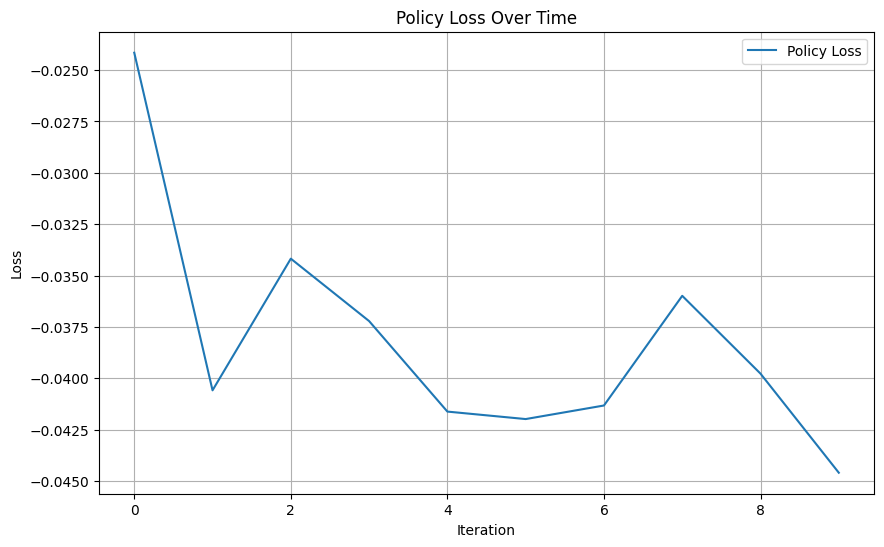

In [24]:
import matplotlib.pyplot as plt

## Visualizes the policy loss over time (or iterations).e
   
plt.figure(figsize=(10, 6))
plt.plot(policy_losses, label='Policy Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Policy Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()